# Numerical Illustrations (Linear)
Setup inspired from Avella-Medina (2017).

We will use a linear model solved using penalized ridge regression to illustrate the statistical influence function bound proven in this paper. 

## Linear Design

We simulate a model $y_i = x_i^T\theta + \mu_i$ for $n=[15, 10,000]$. Each $x_i$ is iid standard normal random variables and $\theta \in \mathbb{R}^9$ is fixed ahead of time. In order to introduce contaimination into the dataset, we let $\mu_i = (1-b_i)N(0,1)+b_iN(0,10)$ and $b_i\sim \text{Bernoulli}(.1)$.


In [5]:
# Simulate Data
import numpy as np
from math import sqrt

# Generate theta*
dim = 9
rng1 = np.random.RandomState(0)
theta_star = rng1.randn(dim)  # Random parameters
theta_star = theta_star / np.linalg.norm(theta_star)  # Make norm = 1

# Simulate training data
def sim_data(eps, n, rng):
    b = np.random.binomial(size=n, n=1, p=eps)  # (n,)
    # Normalize by dimension to small norm
    x = rng.normal(0, 1, size=(n, dim)) / dim  # (n, d)
    mu = (1-b) * rng.normal(0, 1, size=n) + b * \
        rng.normal(0, sqrt(10), size=n)  # (n,)
    y = np.matmul(x, theta_star) + mu
    return x, y

# Simulate contaminated point
def sim_contaminated(n, rng):
    x = rng.normal(0, 1, size=(n, dim)) / dim  # (n, d)
    mu = rng.normal(0, sqrt(10), size=n)  # (n,)
    y = np.matmul(x, theta_star) + mu  # (n,)
    return x, y


# Population Influence Function for Ridge Regression
We will use the following closed form solution for the population influence function provided by Cook and Weisberg (1982).

$I(z)= -H_\star^{-1}\psi(z,\theta_\star)$

where $z=(x,y), x\sim N(0,1), \mu \sim N(0,10), y = x^T\theta^\star + \mu$

We define the following:

$H_\star =  diag(\frac{1}{d^2} + \lambda_1)$ , where $d$ is dimension of $\theta$

$\psi(z,\theta_\star) = \nabla \ell(z,\theta_\star) = -(y-x^T\theta_\star)x +\sum\lambda_1*\theta_\star$



In [7]:
# Population Influence Function
from scipy.linalg import block_diag
import numpy as np
def if_orth_pop(x_con, y_con, oracle_theta, lambda1):
    # Population hessian, use theta=theta_star
    hess = np.eye(dim) * (1 / dim**2 + lambda1)  # H = (1/d^2) I in our case
    grad = (np.dot(x_con, oracle_theta) - y_con) * x_con + np.sum(lambda1*oracle_theta)
    return -np.linalg.solve(hess, grad)

# Empirical Influence Function for Ridge Regression
We will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}(\psi(z,\theta_n))$

where $z=(x,y), x\sim N(0,1), \mu \sim N(0,10), y = x^T\theta^\star + \mu$

We define the following:

$H_n(\theta_n) = \frac1n \sum_{i=1}^n x_ix_i^T + \lambda_1 I$ 

$\psi(z,\theta_n) = \nabla \ell(z,\theta_n) = -(y-x^T\theta_n)x + \sum \lambda_1*\theta_n$

$\theta_n$ is calculated using ridge regression

In [8]:
from scipy.linalg import block_diag
from numpy.linalg import inv
import numpy as np

# Finding theta values using Ridge regression 
from sklearn import linear_model
def ridge(x, y, lambda1):
    hess = np.matmul(x.T, x) + lambda1 * np.eye(x.shape[1])  
    grad = np.matmul(x.T, y) 
    return np.linalg.solve(hess, grad)  

def if_orth_emp(x_sim, y_sim, x_con, y_con, lambda1, n):
    ridge_theta = ridge(x_sim, y_sim, lambda1)
    hess = np.matmul(x_sim.T, x_sim) / n + lambda1 * np.eye(x_sim.shape[1])
    grad = (np.dot(x_con, ridge_theta) - y_con) * x_con+ np.sum(lambda1*ridge_theta)
    return -np.linalg.solve(hess, grad)


# Find `oracle_theta` for the Ridge problem 

We have $\theta_{\lambda}^\star = (E[x x^\top]  + \lambda I)^{-1} E[yx]$. 

But our data generation satisfies $y = x^\top \theta_\star + \epsilon$ so that 
$$
    E[yx] = E[xx^\top] \theta_\star + E[x\epsilon] = H \theta_\star \,.
$$

Therefore, 
$$
    \theta_\lambda^\star = (H  + \lambda I)^{-1} H \theta_\star = \frac{1/d^2}{1/d^2 + \lambda} \theta_\star ,
$$
since $H = (1 / d^2) I$ in our case. 

In [9]:
def find_oracle_theta(lambda1):
    return 1 / (1 + lambda1 * dim * dim) * theta_star

## Run Simulations
We now calculate the difference between the empirical influence and population influence of $100$ simulated contamination datapoint using different training data sample sizes ($n = 15, 55, 202, 742, 2724, 10000$). We consider different penalization parameter values $\lambda_1 = 1e-4, 1e-3, 1e-2$. 


In [10]:
# Runs n_sim number of simulations computing population and empirical IF on one contaminated point
def if_diff_sim(x_sim, y_sim, oracle_theta_dict, lambda1, n, n_sim, seed):
    oracle_theta = oracle_theta_dict[lambda1]
    x_con_ls = []
    y_con_ls = []
    if_emp_ls = []
    if_pop_ls = []
    rng = np.random.RandomState(seed)
    x_con_ls, y_con_ls = sim_contaminated(n_sim, rng)
    for i in range(n_sim):
        x_con = x_con_ls[i]
        y_con = y_con_ls[i]
        if_emp_ls.append(if_orth_emp(x_sim, y_sim, x_con, y_con, lambda1, n))
        if_pop_ls.append(if_orth_pop(x_con, y_con, oracle_theta, lambda1))
    return (x_con_ls, y_con_ls, if_emp_ls, if_pop_ls)

In [11]:
# Run simulation
eps = .1
lambda1_ls = [1e-4, 1e-3, 1e-2]
n_ls = list(np.logspace(np.log10(15),np.log10(10000), 6).astype(int))
n_sim = 100

oracle_theta_dict = {l : find_oracle_theta(l) for l in lambda1_ls}

mean_diff_abs_0 = []
sd_diff_abs_0 = []
mean_diff_abs_1 = []
sd_diff_abs_1 = []
mean_diff_abs_2 = []
sd_diff_abs_2 = []
mean_diff_abs_total = []
sd_diff_abs_total = []
n_samp = []
lambda1 = []

rng = np.random.RandomState(1)

for n in n_ls:
    x_sim, y_sim = sim_data(eps, n, rng)
    for l in lambda1_ls:
        x_con_ls, y_con_ls, if_emp_ls, if_pop_ls = if_diff_sim(x_sim, y_sim, oracle_theta_dict, l, n, n_sim, 1)
        diff_0 = []
        diff_1 = []
        diff_2 = []
        diff_abs_0 = []
        diff_abs_1 = []
        diff_abs_2 = []
        bound_val = []
        for i in range(len(if_emp_ls)):
            diff_abs_0.append(np.abs(if_emp_ls[i][0]-if_pop_ls[i][0]))
            diff_abs_1.append(np.abs(if_emp_ls[i][1]-if_pop_ls[i][1]))
            diff_abs_2.append(np.abs(if_emp_ls[i][2]-if_pop_ls[i][2]))
            diff_abs_total = np.abs(if_emp_ls[i]-if_pop_ls[i])
            bound_val.append(np.dot(np.matmul(diff_abs_total,np.eye(dim) * (1 / dim**2 + l)),np.transpose(diff_abs_total)))
        sd_diff_abs_0.append(np.std(diff_abs_0))
        mean_diff_abs_0.append(np.mean(diff_abs_0))
        sd_diff_abs_1.append(np.std(diff_abs_1))
        mean_diff_abs_1.append(np.mean(diff_abs_1))
        sd_diff_abs_2.append(np.std(diff_abs_2))
        mean_diff_abs_2.append(np.mean(diff_abs_2))
        mean_diff_abs_total.append(np.mean(bound_val))
        sd_diff_abs_total.append(np.std(bound_val))
        n_samp.append(n)
        lambda1.append(l)

## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$

In [12]:
import pandas as pd
bound_val_results = pd.DataFrame({"mean_diff_abs":mean_diff_abs_total, "n":n_samp,"lambda1":lambda1,"sd_diff_abs":sd_diff_abs_total})

def stat_bound(p_star, mu_star,n,delta):
    return((p_star**2)/((mu_star)*n)*np.log(p/delta)**3)
    
p = 9
lambda1_ls = [1e-4, 1e-3, 1e-2]
stat_bound_ls={}
delta = .05
for l in lambda1_ls:
    hess_pop = np.eye(dim) * (1 / dim**l)
    mu_star = np.min(np.linalg.eig(hess_pop)[0])
    n_ls = bound_val_results.loc[bound_val_results['lambda1']== l]['n']
    stat_bound_ls[l]=stat_bound(p,mu_star,n_ls,delta)

## Graph Results
We only graph results for $\lambda_1 = 1e-3$

In [13]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o","X", "s","^", "P"]
line = ["solid", "dotted", "dashed", "dashdot","loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']


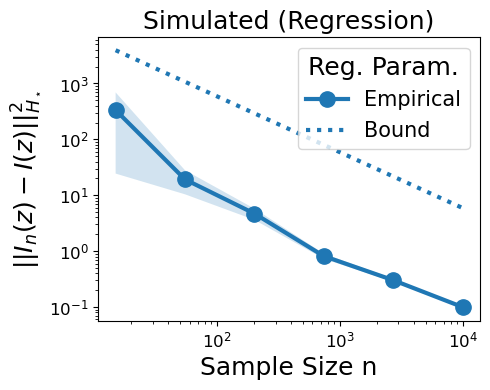

In [17]:
# Graph Results
import pandas as pd
bound_val_results = pd.DataFrame({"mean_diff_abs":mean_diff_abs_total, "n":n_samp,"lambda1":lambda1,"sd_diff_abs":sd_diff_abs_total})
lambda1_ls_name = [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$"]
lambda1_ls = [1e-3]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
for i, l in enumerate(lambda1_ls):
    data = bound_val_results.loc[bound_val_results['lambda1']== l]
    ax.plot(np.abs(data['n']),np.abs(data['mean_diff_abs']),label = "Empirical", color = COLORS[i], marker = shape[i], linestyle = line[i], markersize = 11)
    ax.fill_between(np.abs(data['n']), np.abs(data['mean_diff_abs']-1.96*data['sd_diff_abs']/np.sqrt(data['n'])), np.abs(data['mean_diff_abs']+1.96*data['sd_diff_abs']/np.sqrt(data['n'])), alpha=0.2)
    ax.plot(np.abs(data['n']), stat_bound_ls[l], color = COLORS[i], linestyle = line[1],label = "Bound")

ax.set_ylabel(r'$\|\| I_{n}(z) - I(z) \|\|_{H_\star}^2$')
ax.set_xlabel("Sample Size n")
ax.set_title('Simulated (Regression)')
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='upper right', borderpad=.15, labelspacing=.2)

plt.legend(loc='upper right', title='Reg. Param.', title_fontsize = 18)
plt.tight_layout()

plt.savefig("../../graphs/simulation_linear_bound.pdf")
plt.savefig("../../graphs/simulation_linear_bound.png")